# TDA@HSE+YSDA, 2024

## Seminar 9

In [ ]:
!pip install --upgrade Cython
!pip install --upgrade Ripser
!pip install --upgrade diagram2vec
!pip install --upgrade giotto-tda

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

from ripser import lower_star_img
from ripser import Rips
vr = Rips()
from gtda.homology import VietorisRipsPersistence

import persim
import diagram2vec

from scipy.ndimage import gaussian_filter

from sklearn.datasets import make_circles
from sklearn.manifold import MDS

from gtda.diagrams import PersistenceEntropy, PersistenceImage, BettiCurve

import pickle
from tqdm import tqdm

import torch
from torch.nn import Linear
from torch.nn.functional import relu

from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from sklearn.model_selection import cross_val_score

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [9]:
def diagram_reshape(diagram):
    zero_idx = np.where(diagram[:,2]==0)
    one_idx = np.where(diagram[:,2]==1)
    return diagram[zero_idx], diagram[one_idx]

## 1. Persistent diagrams, Wasserstein distance and stability

In [10]:
# original data
X, y = make_circles(n_samples=200, noise=0.1)
X = X[y==0]

Topology studies data invariant to continous transformations, so topological invariants like (persistent) homology will not change under such class of transformations.

**Exercise**

Apply rotation and dilation transformations to copy of original data.

In [11]:
theta = np.radians(30)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c,-s), (s, c)))
print(R)

[[ 0.8660254 -0.5      ]
 [ 0.5        0.8660254]]


In [12]:
# transformed data
X_transformed = np.copy(X)
X_transformed[:,0] = X[:,0] * 0.75
X_transformed = np.dot(X_transformed, R)

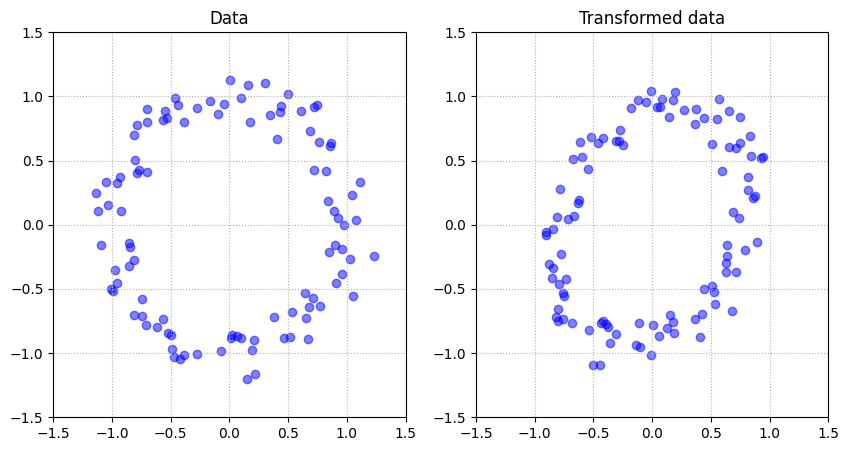

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].set_title("Data")
ax[0].set_xlim(-1.5, 1.5)
ax[0].set_ylim(-1.5, 1.5)
ax[0].grid(linestyle="dotted")
ax[0].scatter(X[:,0], X[:,1], c="b", alpha=0.5)

ax[1].set_title("Transformed data")
ax[1].set_xlim(-1.5, 1.5)
ax[1].set_ylim(-1.5, 1.5)
ax[1].grid(linestyle="dotted")
ax[1].scatter(X_transformed[:,0], X_transformed[:,1], c="b", alpha=0.5)

plt.show()

**Exercise**

Compute persistence diagrams of a filtration of Vietoris-Rips complex built on point cloud data

In [14]:
diagram = vr.fit_transform(X)
diagram_transformed = vr.fit_transform(X_transformed)

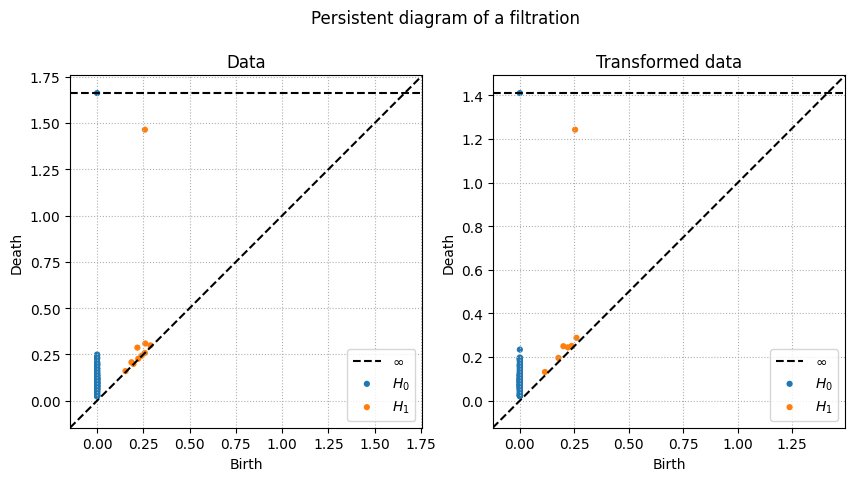

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
plt.suptitle("Persistent diagram of a filtration")

ax[0].set_title("Data")
ax[0].grid(linestyle="dotted")
vr.plot(diagram, ax=ax[0])

ax[1].set_title("Transformed data")
ax[1].grid(linestyle="dotted")
vr.plot(diagram_transformed, ax=ax[1])

plt.show()

One can define the geometry on the space of persistent diagrams, defining a metric on it. Optimal transport approach is used to compare persistent diagrams which are multisets of intervals of arbitrary cardinality.  

The variants of optimal transport distances are _Wasserstein-2 distance_, and its approximations like _sliced Wasserstein distance_ and _Bollteneck distance_, which is Wasserstein-$\infty$ distance.

**Exercise**

Compute Bottleneck `persim.bottleneck` and sliced Wasserstein distances `persim.sliced_wasserstein` between perisistent diagrams of original and transformed data.

In [16]:
diagram

[array([[0.        , 0.022501  ],
        [0.        , 0.02389783],
        [0.        , 0.02565466],
        [0.        , 0.02601673],
        [0.        , 0.02617963],
        [0.        , 0.02901145],
        [0.        , 0.02942659],
        [0.        , 0.03604896],
        [0.        , 0.03829386],
        [0.        , 0.04581751],
        [0.        , 0.04615475],
        [0.        , 0.04878433],
        [0.        , 0.04995468],
        [0.        , 0.05376792],
        [0.        , 0.05524153],
        [0.        , 0.06051081],
        [0.        , 0.06155768],
        [0.        , 0.06251393],
        [0.        , 0.0646081 ],
        [0.        , 0.06489664],
        [0.        , 0.06501882],
        [0.        , 0.06507478],
        [0.        , 0.06592685],
        [0.        , 0.07324906],
        [0.        , 0.07446429],
        [0.        , 0.07458032],
        [0.        , 0.07464583],
        [0.        , 0.07740503],
        [0.        , 0.07754875],
        [0.   

In [19]:
diagram[0].shape

(100, 2)

In [20]:
diagram_transformed[0].shape

(100, 2)

In [22]:
persim.bottleneck(diagram[1], diagram_transformed[1]) # pc w noise=0.1 vs w/ noise 0.12

0.22095119953155518

In [23]:
persim.sliced_wasserstein(diagram[1], diagram_transformed[1])

0.29632707704061356

Bottleneck distance used a single matching between most discriminative pair of points.

**Exercise**

Visualize Bottleneck matching.

In [24]:
# compute Bottleneck distance matching
d, matching = persim.bottleneck(diagram[1], diagram_transformed[1], matching=True)

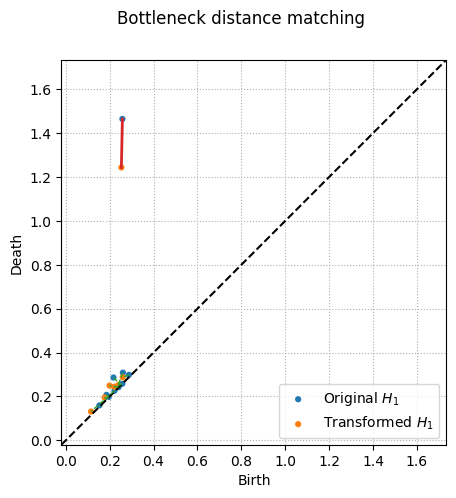

In [25]:
# plot Bottleneck distance matchign
fig, ax = plt.subplots(figsize=(10, 5))
plt.suptitle("Bottleneck distance matching")
ax.grid(linestyle="dotted")
persim.bottleneck_matching(diagram[1], diagram_transformed[1], matching, labels=['Original $H_1$', 'Transformed $H_1$'], ax=ax)
plt.show()

For Bottleneck distance stability to small perturbations is theoretically proved.

**Exercise**

Plot Bottleneck distance with respect to different level of Gaussian noise applied to original data.

In [26]:
n_samples = 200

n_noise_levels = 11
n_repeats = 10

# original data
X_orig, y = make_circles(n_samples=n_samples, noise=0.0)
X_orig = X_orig
diagram_orig = vr.fit_transform(X_orig)

distances = np.zeros((n_noise_levels, n_repeats))

for j in tqdm(range(n_repeats)):
    for i, noise_level in enumerate(np.linspace(0, 0.2, n_noise_levels)):

        X_noisy, _ = make_circles(n_samples=n_samples, noise=noise_level)
        X_noisy = X_noisy

        diagram_noise = vr.fit_transform(X_noisy)
        
        distances[i,j] = persim.bottleneck(diagram_orig[1], diagram_noise[1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.12s/it]


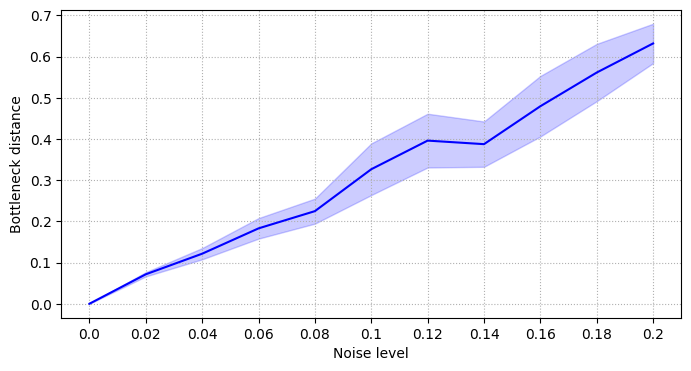

In [27]:
fig, ax = plt.subplots(figsize=(8,4))
ax.set_xlabel("Noise level")
ax.set_ylabel("Bottleneck distance")
ax.set_xticks(range(n_noise_levels), np.linspace(0, 0.2, n_noise_levels))
ax.grid(linestyle="dotted")
ax.plot(distances.mean(axis=1), c="b")

std = distances.std(axis=1)
lower = distances.mean(axis=1) - std
upper = distances.mean(axis=1) + std
ax.fill_between(range(n_noise_levels), lower, upper, color='b', alpha=.2)

plt.show()

## 3. Persistent homology of graphs

Pipeline is as follows:

1. compute persistent diagrams via Ripser 
2. compute vectorization of diagrams, so-called persistent images and Betti curves
3. apply classifier on vectorization

In [28]:
# load data
X_graphs = pickle.load(open("./data/metric_graphs/X.pkl", "rb"))
y_all = pickle.load(open("./data/metric_graphs/y_all.pkl", "rb"))
y_dnod = pickle.load(open("./data/metric_graphs/y_d_nod.pkl", "rb"))

y_col = ["a"] * len(y)
y_col = np.array(y_col)

y_col[y==0] = "blue"
y_col[y==2] = "green"
y_col[y==1] = "red"
y_col[y==3] = "yellow"

### Compute persistent diagrams

In [29]:
# add h_1 diagrams only
maxdim = 1
h = 1

rips = Rips(maxdim=maxdim)

diagrams = []
for x in X_graphs:
    diagrams.append(rips.fit_transform(x, distance_matrix=True)[h])

len(diagrams)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


100

### Clusterization

In [30]:
%%time
n = len(X_graphs)
distances = np.zeros((n, n))

for i in tqdm(range(0, n)):
    for j in range(i+1, n):
        distances[i,j] = persim.sliced_wasserstein(diagrams[i], diagrams[j])
        
distances_symmetrize = distances + distances.T

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]

CPU times: user 1min 23s, sys: 631 ms, total: 1min 24s
Wall time: 1min 24s


In [32]:
distances_symmetrize = distances + distances.T

In [33]:
mds = MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", random_state=1, n_jobs=-1)
X_metric = mds.fit(distances_symmetrize).embedding_

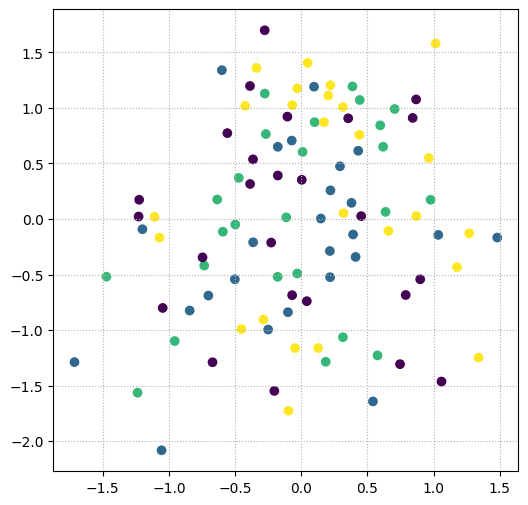

In [34]:
plt.figure(figsize=(6,6))
plt.grid(linestyle="dotted")

plt.scatter(X_metric[:, 0], X_metric[:, 1], c=y_all)
plt.show()

### Vectorization

Persistent diagram is a multiset of intervals of arbitrary length which is can not be handled by methods of machine learning. One possible to solutions besides providing a metric on the space of persistent diagrams is vectorization of diagrams to a vector of fixed length.

In [35]:
vr = VietorisRipsPersistence()
diagrams = vr.fit_transform(X_graphs)

In [36]:
diagrams.shape

(100, 252, 3)

#### Betti curve

In [37]:
n_bins_curve = 50

betti_curves = BettiCurve(n_bins=n_bins_curve).fit_transform(diagrams)
betti_curves.shape

(100, 2, 50)

#### Persistence image

In [38]:
n_bins_image = 15

persistence_images = PersistenceImage(sigma=0.1, n_bins=n_bins_image).fit_transform(diagrams)
persistence_images.shape

(100, 2, 15, 15)

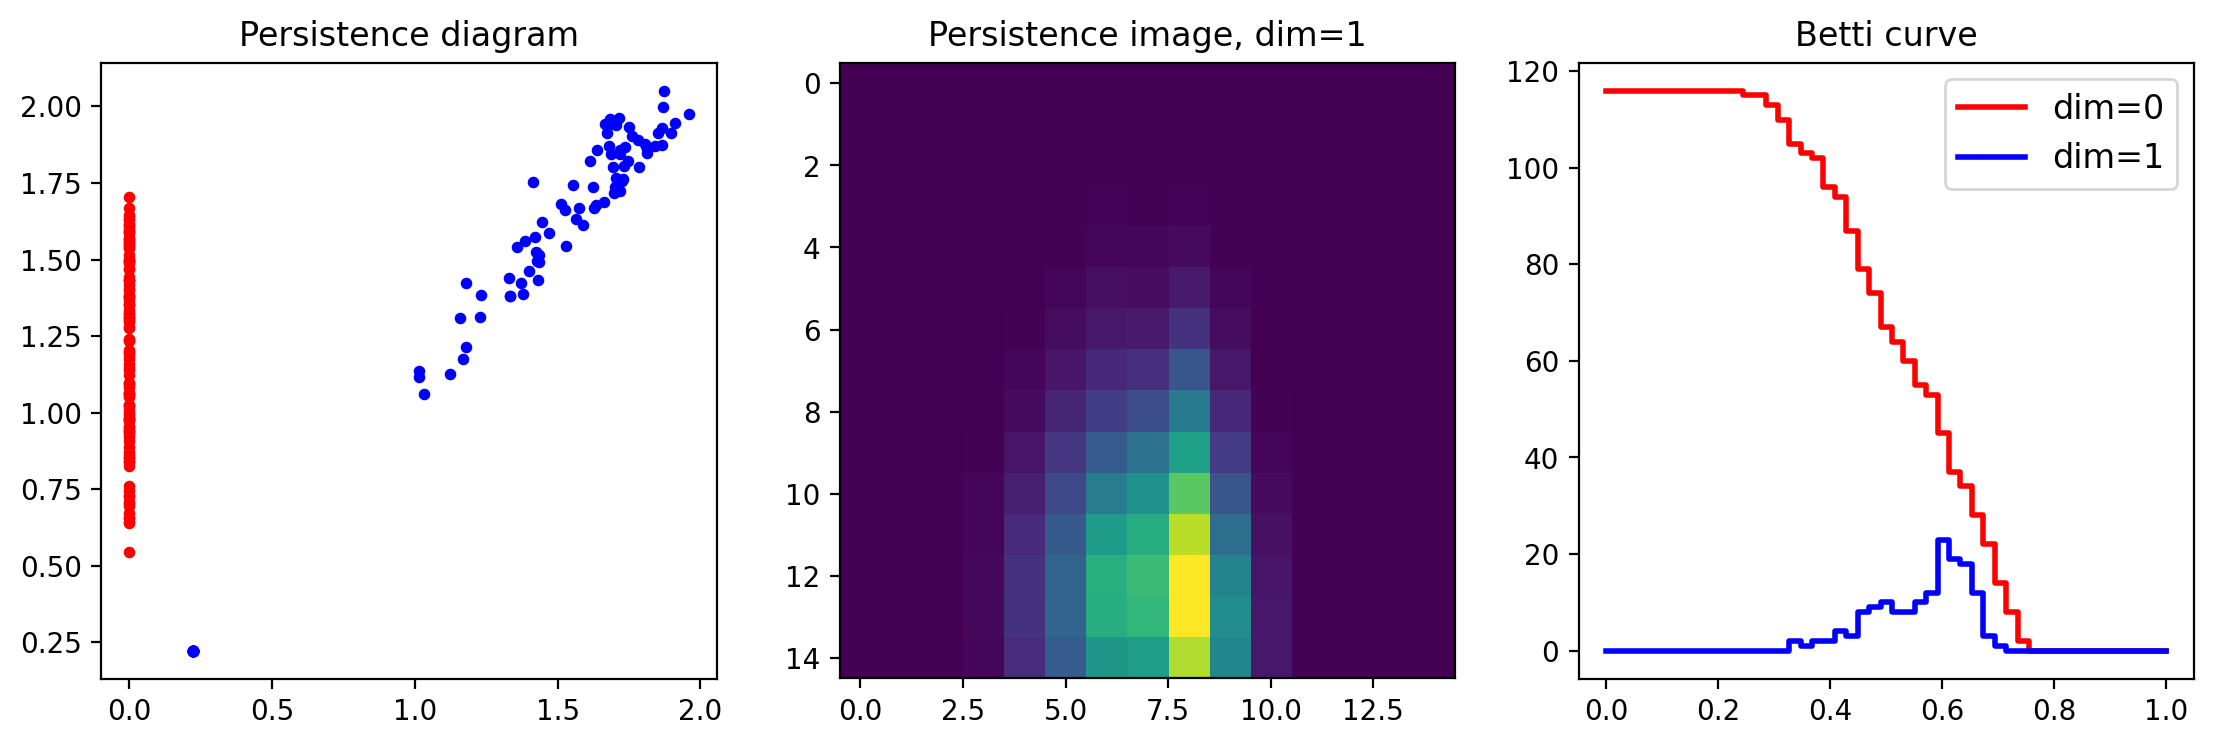

In [40]:
idx = 30

diagram0, diagram1 = diagram_reshape(diagrams[idx])

fig, ax = plt.subplots(ncols=3, figsize=(13.5, 4), dpi=200)
ax[0].set_title("Persistence diagram")
ax[1].set_title("Persistence image, dim=1")
ax[2].set_title("Betti curve")

# persistence diagram
ax[0].scatter(diagram0[:,0], diagram0[:,1], s=10, c="r")
ax[0].scatter(diagram1[:,0], diagram1[:,1], s=10, c="b")

# persistence image
ax[1].imshow(persistence_images[idx][1])

# Betti curve
ax[2].step(np.linspace(0,1,50), betti_curves[idx,0], color="r", where="post", linewidth=2, label="dim=0")
ax[2].step(np.linspace(0,1,50), betti_curves[idx,1], color="b", where="post", linewidth=2, label="dim=1")
ax[2].legend(fontsize=12)

plt.show()

### Classification

#### Persistence images

In [41]:
X_control = persistence_images[y_all==0]
X_depression = persistence_images[y_all==1]

X = np.concatenate((X_control, X_depression), axis=0)
X0 = X[:,0].reshape(-1, n_bins_image**2)
X1 = X[:,1].reshape(-1, n_bins_image**2)
y = np.concatenate((np.zeros(25), np.ones(25)), axis=0)

In [43]:
clf = LogisticRegression(penalty="l2", C=5.0, solver="liblinear", random_state=42)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

In [44]:
acc_pi_h0 = cross_val_score(clf, X0, y, cv=cv)
print("Accuracy, PI, H0: {:.4f} ± {:.4f}".format(np.mean(acc_pi_h0), np.std(acc_pi_h0)))

Accuracy, PI, H0: 0.6760 ± 0.1365


In [45]:
acc_pi_h1 = cross_val_score(clf, X1, y, cv=cv)
print("Accuracy, PI, H1: {:.4f} ± {:.4f}".format(np.mean(acc_pi_h1), np.std(acc_pi_h1)))

Accuracy, PI, H1: 0.5560 ± 0.1444


#### Betti curves

In [46]:
X_control = betti_curves[y_all==0]
X_depression = betti_curves[y_all==1]
X = np.concatenate((X_control, X_depression), axis=0)
X0 = X[:,0].reshape(-1, n_bins_curve)
X1 = X[:,1].reshape(-1, n_bins_curve)
y = np.concatenate((np.zeros(25), np.ones(25)), axis=0)

In [47]:
clf = RandomForestClassifier(random_state=42)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

In [48]:
acc_curve_h0 = cross_val_score(clf, X0, y, cv=cv)
print("Accuracy, Betti curve, H0: {:.4f} ± {:.4f}".format(np.mean(acc_curve_h0), np.std(acc_curve_h0)))

Accuracy, Betti curve, H0: 0.6560 ± 0.1499


In [49]:
acc_curve_h1 = cross_val_score(clf, X1, y, cv=cv)
print("Accuracy, Betti curve, H1: {:.4f} ± {:.4f}".format(np.mean(acc_curve_h1), np.std(acc_curve_h1)))

Accuracy, Betti curve, H1: 0.4600 ± 0.1233


## 4. Persistent homology of digital images

Persistence Diagrams with Linear Machine Learning Models (Obayashi, Hiraoka), 2017  
https://arxiv.org/abs/1706.10082

In [50]:
W = 300
sigma1 = 4
sigma2 = 2
t = 0.01

def generate(N, S, W=300, sigma1=4, sigma2=2, t=0.01, bins=64):

    z = np.zeros((N, S, 2))
    for n in range(N):
        z[n, 0] = np.random.uniform(0, W, size=(2))
        for s in range(S-1):
            d_1 = np.random.normal(0, sigma1)
            d_2 = np.random.normal(0, sigma1)
            z[n, s+1, 0] = (z[n, s, 0] + d_1) % W
            z[n, s+1, 1] = (z[n, s, 1] + d_2) % W

    z_r = z.reshape(N*S, 2)
    H, _, _ = np.histogram2d(z_r[:,0], z_r[:,1], bins=bins)
    
    G = gaussian_filter(H, sigma2)
    G[G < t] = 0
    
    return G

### Image generation

Generate 100 images accoring to model A and model B

In [60]:
images = np.zeros((100,64,64))

# class A
N = 150
S = 20

for n in range(50):
    images[n] = generate(N, S)
    
# class B
N = 250
S = 10

for n in range(50):
    images[n+50] = generate(N, S)

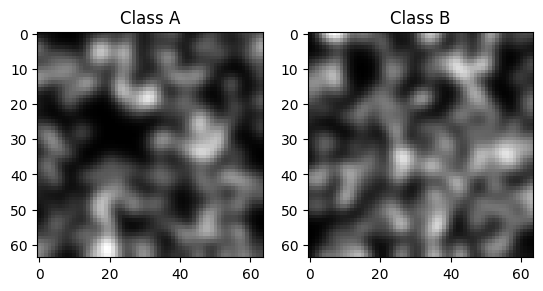

In [61]:
fig = plt.figure()
plt.gray()

ax1 = fig.add_subplot(121)
plt.title("Class A")

ax2 = fig.add_subplot(122)
plt.title("Class B")

ax1.imshow(images[int(np.random.uniform(1, 50))])
ax2.imshow(images[int(np.random.uniform(52, 100))])

plt.show()

### Compute persistent diagrams

In [62]:
diags = []

for i in range(images.shape[0]):
    diags.append(lower_star_img(images[i])[:-1])

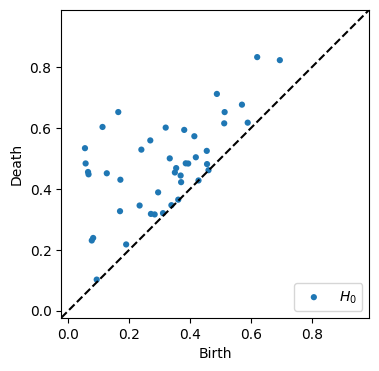

In [63]:
plt.figure(figsize=(4,4))
persim.plot_diagrams(diags[52])

### Vectorization

In [85]:
betti_curves = diagram2vec.entropy_curve(diags, quantity="persistence", m=50)
betti_curves.shape

(1, 100, 50)

### Classification

#### Betti curves

In [86]:
X_betti_curves = betti_curves[0]
y = np.concatenate((np.zeros(50), np.ones(50)), axis=0)

y_col = ["b"] * len(y)
y_col = np.array(y_col)

y_col[y==1] = "r"

In [87]:
clf = RandomForestClassifier(random_state=42)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

In [88]:
acc_curve_h0 = cross_val_score(clf, X_betti_curves, y, cv=cv)
print("Accuracy, Betti curve, H0: {:.4f} ± {:.4f}".format(np.mean(acc_curve_h0), np.std(acc_curve_h0)))

Accuracy, Betti curve, H0: 0.8300 ± 0.0800


### Clusterization

**Exercise**

Compute the two-dimensional embeddings using linear and nonlinear techniques learned during the course, given persistent images, Betti curves and pairwise distances between data points.

In [89]:
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, SpectralEmbedding

In [90]:
X_emb = Isomap().fit_transform(X_betti_curves)

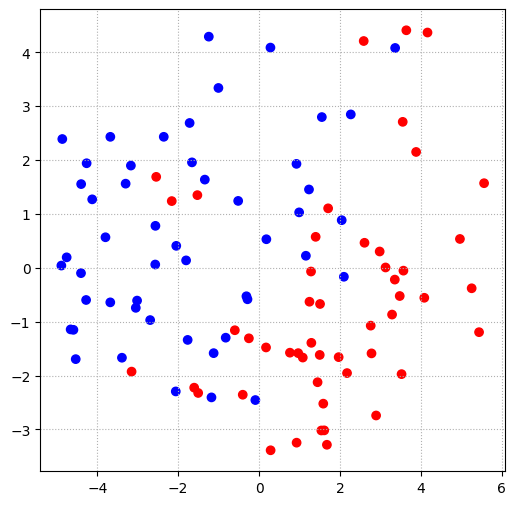

In [91]:
plt.figure(figsize=(6,6))
plt.grid(linestyle="dotted")

plt.scatter(X_emb[:, 0], X_emb[:, 1], c=y_col)
plt.show()

## 5. Deep sets

#### Problem
Persistence diagram is a multiset of vectors $D = \{(b_i, d_i, h_i)\}_{i=1}^N$ where $b_i$, $d_i$ are the birth and death times of $i$-th topological feature of dimension $h_i$. The classic approach to introduce persistent diagrams to machine learning is related to distances and kernels defined on the space of diagrams, which takes $O(n^2)$ time to compute. Vectrorization schemes such as persistence [images](https://arxiv.org/abs/1507.06217), [landscapes](https://arxiv.org/abs/1501.00179) or [curves](https://arxiv.org/abs/1904.07768) reduce the time to $O(n)$, yet all of this approaches are more or less fixed.

Trainable vectorization allows to learn vector representations of persistence diagrams, optimal w.r.t. the downstream task such as classification or regression. The simplest of such models, [Deep Sets](https://arxiv.org/abs/1703.06114) - $f: (\mathbb{R}^3)^N \rightarrow \mathbb{R}^d$

\begin{equation}
f(\{x_1, \dots, x_N\}) = \rho \left( \sum_{i=1}^N \phi(x_i) \right),
\end{equation}

consists of an encoder $\phi_\theta: \mathbb{R}^3 \rightarrow \mathbb{R}^D$ mapping each diagram point $x_i = (b_i, d_i, h_i)$, with parameters $\theta$ shared between points, a permutation invariant pooling operation $(\cdot): (\mathbb{R}^D)^N \rightarrow \mathbb{R}^D$ to obtain a representation of a diagram at whole (particulary for Deep Sets - sum pooling), and a decoder $\rho: \mathbb{R}^D \rightarrow \mathbb{R}^d$ which further transforms the diagram representation. It was [shown](https://arxiv.org/abs/1904.09378) that certain combinations of encoder/pooling/decoder correspond to the fixed representation schemes of persistence diagrams.

Deep sets encoder vectorizes each single point independently and does not consider the interdependence between points in the diagram. Thus, the self-attention block from the Transformer model which allows to capture those dependencies is a natural plug-in replacement to the encoder $\phi$.

\begin{equation}
\Phi_{ATTN}(\{x_1, \dots, x_N\}) = \left(\frac{(\mathbf{W}_q \mathbf{X})(\mathbf{W}_k \mathbf{X})^T}{\sqrt{D}} \right)\mathbf{W}_v\mathbf{X},
\end{equation}

where $\Phi_{ATTN}: (\mathbb{R}^3)^N \rightarrow (\mathbb{R}^D)^N$.

In [92]:
def generate_orbit(point_0, r, n=300):
    
    X = np.zeros([n, 2])
    
    xcur, ycur = point_0[0], point_0[1]
    
    for idx in range(n):
        xcur = (xcur + r * ycur * (1. - ycur)) % 1
        ycur = (ycur + r * xcur * (1. - xcur)) % 1
        X[idx, :] = [xcur, ycur]
    
    return X

def generate_orbits(m, rs=[2.5, 3.5, 4.0, 4.1, 4.3], n=300, random_state=None):
    
    # m orbits, each of n points of dimension 2
    orbits = np.zeros((m * len(rs), n, 2))
    
    # for each r
    for j, r in enumerate(rs):

        # initial points
        points_0 = random_state.uniform(size=(m,2))

        for i, point_0 in enumerate(points_0):
            orbits[j*m + i] = generate_orbit(points_0[i], rs[j])
            
    return orbits

In [93]:
random_state = np.random.RandomState(42)
X_orbit5k = generate_orbits(1000, random_state=random_state)

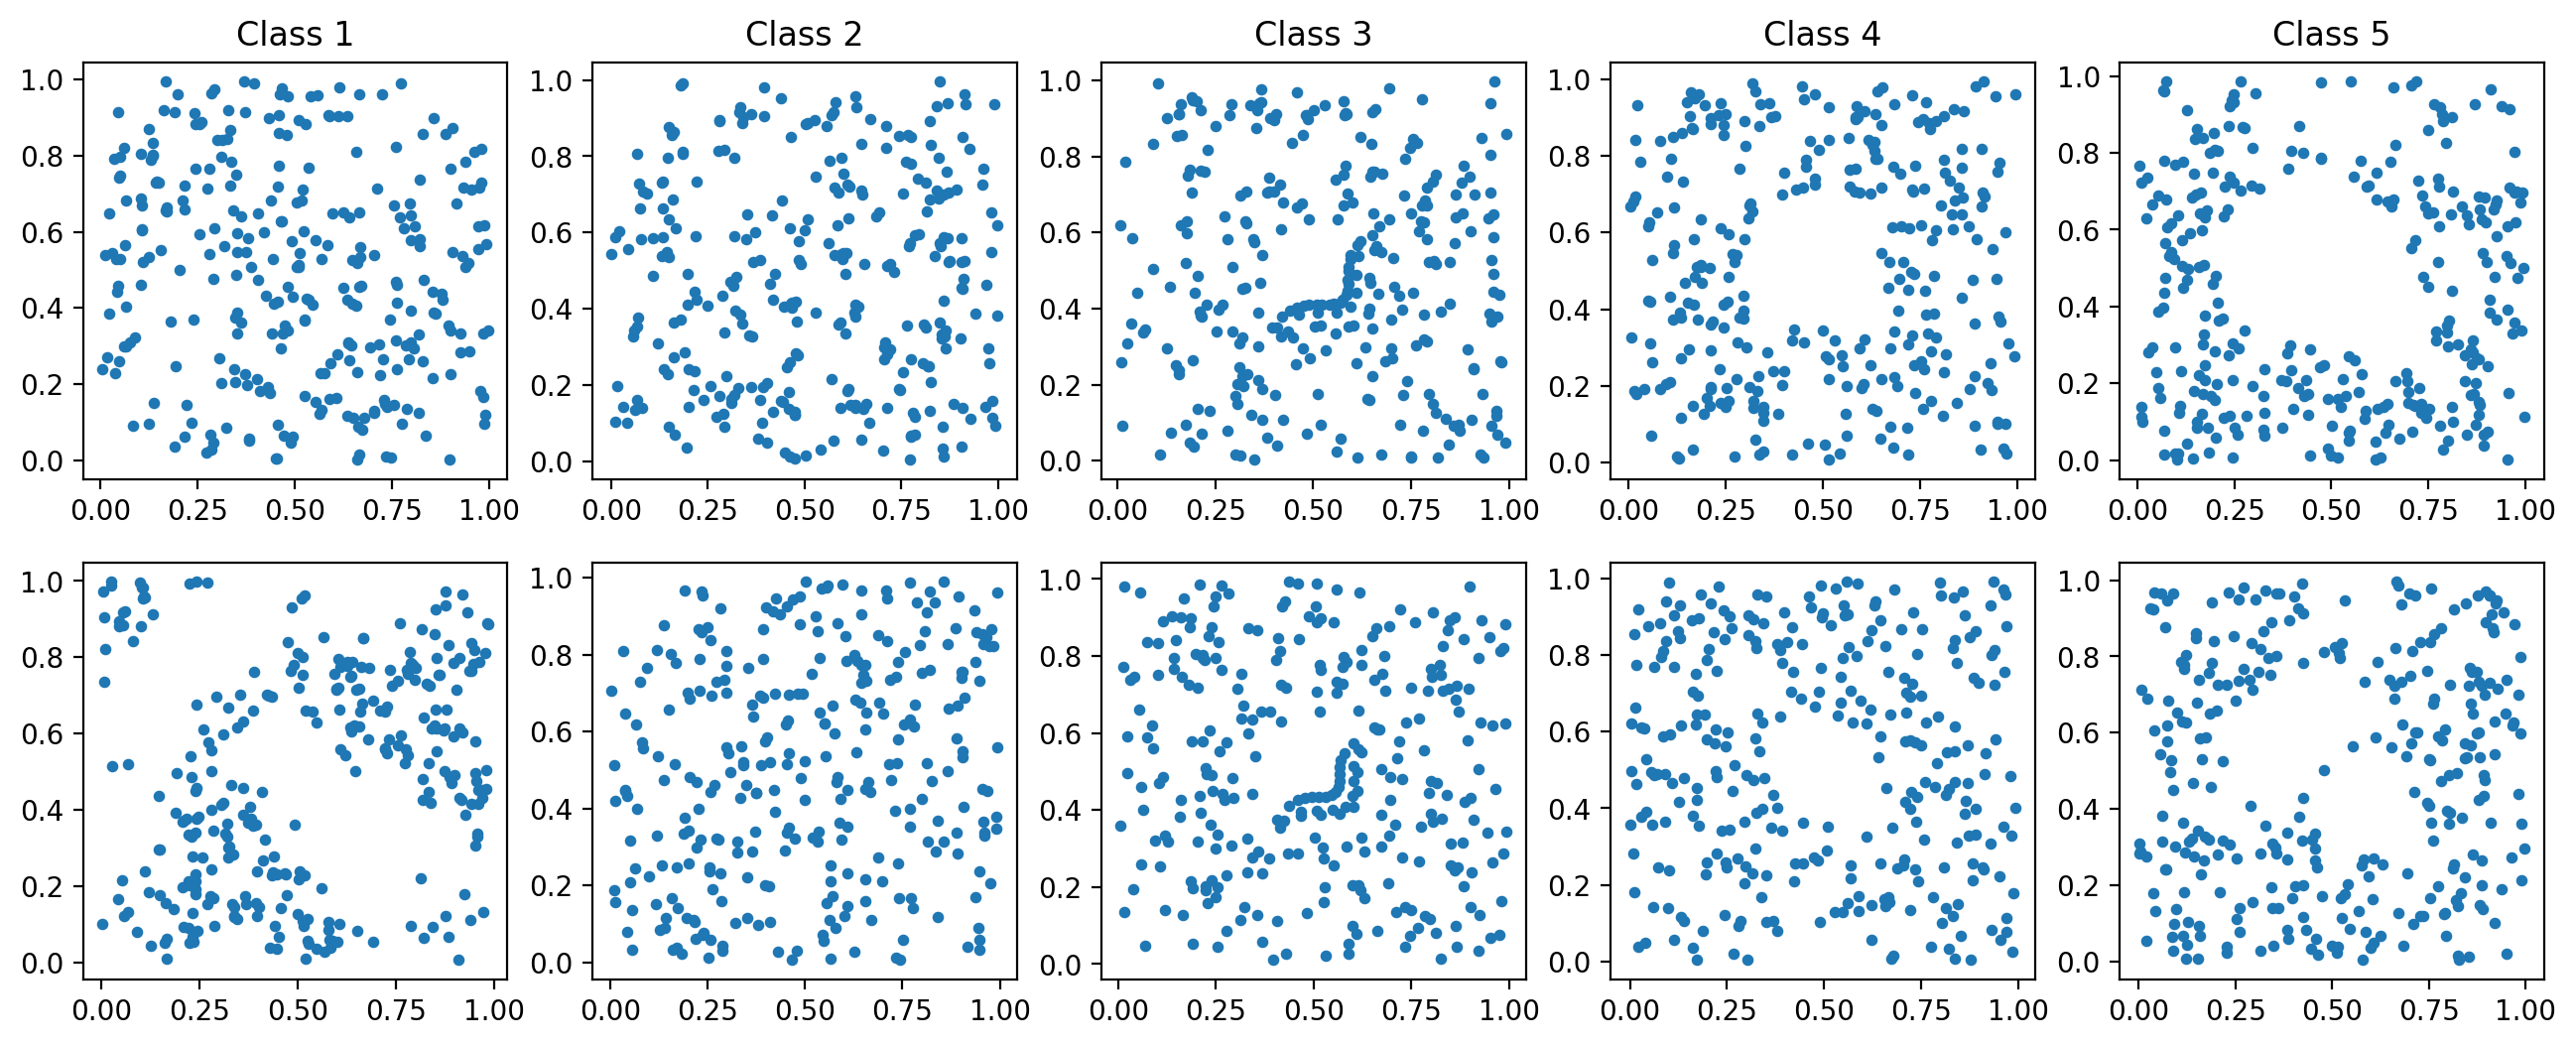

In [94]:
fig, ax = plt.subplots(2, 5, figsize=(16, 6), dpi=200)
for i in range(2):
    for j in range(5):
        if i==0:
            ax[i,j].set_title("Class {}".format(j+1))
        ax[i,j].scatter(X_orbit5k[j*1000+i,:,0], X_orbit5k[j*1000+i,:,1], s=10)

In [95]:
X_pc = np.concatenate((X_orbit5k[2000:3000], X_orbit5k[4000:5000]))
y = np.concatenate((np.zeros(1000), np.ones(1000)))

In [96]:
def conv_pd(diagrams):
    pd = np.zeros((0, 3))

    for k, diagram_k in enumerate(diagrams):
        diagram_k = diagram_k[~np.isinf(diagram_k).any(axis=1)] # filter infs  
        diagram_k = np.concatenate((diagram_k, k * np.ones((diagram_k.shape[0], 1))), axis=1)
        pd = np.concatenate((pd, diagram_k))

    return pd

In [97]:
X = []
vr = Rips()

for x_pc in tqdm(X_pc):
    diagram = conv_pd(vr.fit_transform(x_pc))
    X.append(diagram)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:19<00:00, 25.16it/s]


#### Dataset 

In [98]:
class Orbit2kDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def collate_fn(data):
    
    tmp_pd, _ = data[0]
    
    n_batch = len(data)
    n_features_pd = tmp_pd.shape[1]
    n_points_pd = max(len(pd) for pd, _ in data)
    inputs_pd = np.zeros((n_batch, n_points_pd, n_features_pd), dtype=float)
    labels = np.zeros(len(data))
    
    for i, (pd, label) in enumerate(data):
        inputs_pd[i][:len(pd)] = pd
        labels[i] = label
    
    return torch.Tensor(inputs_pd), torch.Tensor(labels).long()

#### Model

In [100]:
class DeepSets(torch.nn.Module):
    def __init__(self, n_in, n_hidden_enc, n_out_enc, n_hidden_dec=16, n_out_dec=2):
        super(DeepSets, self).__init__()
        self.encoder = Encoder(n_in, n_hidden_enc, n_out_enc)
        self.decoder = MLP(n_out_enc, n_hidden_dec, n_out_dec)
        
    def forward(self, X):
        z_enc = self.encoder(X)
        z = self.decoder(z_enc)
        return z
    
class MLP(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(MLP, self).__init__()
        self.linear1 = Linear(n_in, n_hidden)
        self.linear2 = Linear(n_hidden, n_out)
        
    def forward(self, X):
        X = relu(self.linear1(X))
        X = self.linear2(X)
        return X
    
class Encoder(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(Encoder, self).__init__()
        self.mlp = MLP(n_in, n_hidden, n_out)
        
    def forward(self, X):
        X = self.mlp(X)
        x = X.mean(dim=1) # aggregation
        return x

#### Train

In [101]:
%%time
n_repeats = 3
n_epochs = 100
batch_size = 16
lr = 0.001

n_train, n_test = 1600, 400

history = np.zeros((n_repeats, n_epochs, 3))
criterion = CrossEntropyLoss()

dataset = Orbit2kDataset(X, y)

for repeat_idx in range(n_repeats):
    
    # data init
    dataset_train, dataset_test = random_split(dataset, [n_train, n_test])
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_test =  DataLoader(dataset_test, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    
    # model init
    model = DeepSets(n_in=3, n_hidden_enc=16, n_out_enc=8)
    optimizer = Adam(model.parameters(), lr=lr)
    
    print("{:3} {:6} {:6} {:6}".format(repeat_idx, "Loss", "Train", "Test"))
    
    for epoch_idx in range(n_epochs):
        
        # train
        model.train()
        
        loss_epoch = []
        for batch in dataloader_train:
            loss_batch = criterion(model(batch[0]), batch[1])
            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_epoch.append(loss_batch.detach())
        
        loss_epoch_mean = np.array(loss_epoch).mean()
        history[repeat_idx,epoch_idx,0] = loss_epoch_mean
        
        # test
        model.eval()
        
        correct = 0
        for batch in dataloader_train:
            y_hat = model(batch[0]).argmax(dim=1)
            correct += int((y_hat == batch[1]).sum())
        accuracy_train = correct / len(dataloader_train.dataset)
        history[repeat_idx,epoch_idx,1] = accuracy_train

        correct = 0
        for batch in dataloader_test:
            y_hat = model(batch[0]).argmax(dim=1)
            correct += int((y_hat == batch[1]).sum())
        accuracy_test = correct / len(dataloader_test.dataset)
        history[repeat_idx,epoch_idx,2] = accuracy_test
        
        print("{:3} {:.4f} {:.4f} {:.4f}".format(epoch_idx, loss_epoch_mean, accuracy_train, accuracy_test))
    print("\r")

  0 Loss   Train  Test  
  0 0.6933 0.5050 0.4800
  1 0.6932 0.5050 0.4800
  2 0.6927 0.5050 0.4800
  3 0.6918 0.5238 0.5425
  4 0.6907 0.5244 0.5475
  5 0.6880 0.5513 0.5925
  6 0.6842 0.5250 0.5475
  7 0.6813 0.5962 0.6125
  8 0.6741 0.6419 0.6625
  9 0.6657 0.5431 0.5200
 10 0.6578 0.6450 0.6650
 11 0.6484 0.6594 0.6775
 12 0.6415 0.6544 0.6625
 13 0.6343 0.6538 0.6650
 14 0.6359 0.6550 0.6675
 15 0.6333 0.6525 0.6600
 16 0.6197 0.6475 0.6750
 17 0.6168 0.6106 0.6425
 18 0.6165 0.6650 0.6525
 19 0.6136 0.6669 0.6750
 20 0.6097 0.6481 0.6900
 21 0.6156 0.6644 0.6800
 22 0.6133 0.6600 0.6950
 23 0.6137 0.6587 0.6850
 24 0.6117 0.6312 0.6475
 25 0.6078 0.6663 0.6850
 26 0.6086 0.6569 0.6600
 27 0.6063 0.6719 0.6750
 28 0.6116 0.6687 0.6800
 29 0.6033 0.6538 0.6925
 30 0.6017 0.6750 0.6800
 31 0.6043 0.6775 0.6750
 32 0.5981 0.6750 0.6725
 33 0.5997 0.6725 0.6850
 34 0.5991 0.6550 0.6875
 35 0.5993 0.6825 0.6900
 36 0.5986 0.6763 0.6775
 37 0.6002 0.6550 0.6800
 38 0.5968 0.6606 0.7125


In [102]:
x = np.arange(n_epochs)
loss_ci1 = history.mean(axis=0)[:,0] - history.std(axis=0)[:,0]
loss_ci2 = history.mean(axis=0)[:,0] + history.std(axis=0)[:,0]
acc_train_ci1 = history.mean(axis=0)[:,1] - history.std(axis=0)[:,1]
acc_train_ci2 = history.mean(axis=0)[:,1] + history.std(axis=0)[:,1]
acc_test_ci1 = history.mean(axis=0)[:,2] - history.std(axis=0)[:,2]
acc_test_ci2 = history.mean(axis=0)[:,2] + history.std(axis=0)[:,2]

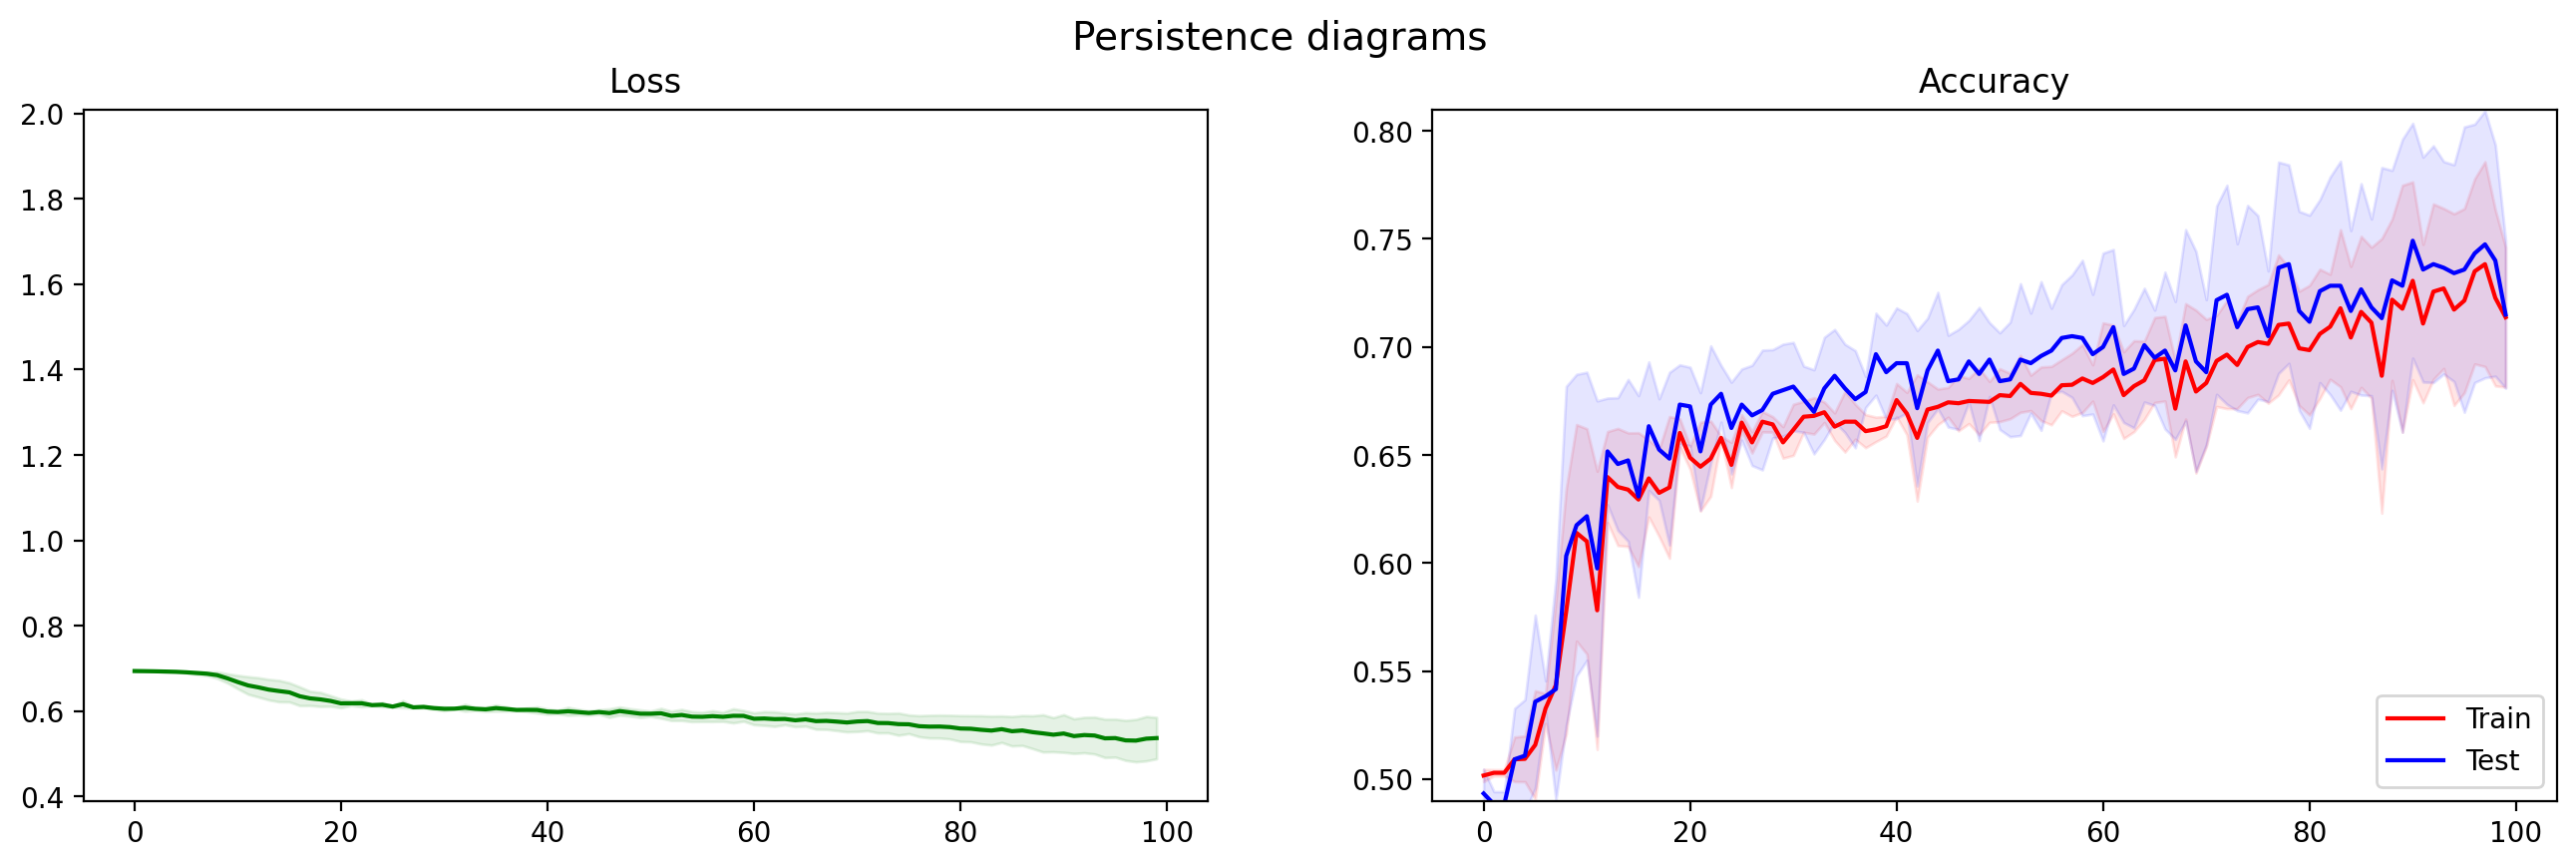

In [103]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
fig.suptitle("Persistence diagrams", fontsize=14)
ax[0].set_title("Loss")
ax[1].set_title("Accuracy")
ax[0].set_ylim(0.39, 2.01)
ax[1].set_ylim(0.49, 0.81)
ax[0].plot(history.mean(axis=0)[:,0], c="g")
ax[0].fill_between(x, loss_ci1, loss_ci2, color="g", alpha=0.1)
ax[1].plot(history.mean(axis=0)[:,1], c="r", label="Train")
ax[1].plot(history.mean(axis=0)[:,2], c="b", label="Test")
ax[1].fill_between(x, acc_train_ci1, acc_train_ci2, color="r", alpha=0.1)
ax[1].fill_between(x, acc_test_ci1, acc_test_ci2, color="b", alpha=0.1)
ax[1].legend(loc=4)
plt.show()